In [1]:
import time
import math
import argparse

import numpy as np

from swarm import Swarm



In [2]:
#ArgParser:
parser = argparse.ArgumentParser(description="Example script with argparse")

parser.add_argument('--outputFile', type=str,default='../data/logs/defaultLogfile', help='Path where the output should be stored')
parser.add_argument('--numDrones', type=int, default=5, help='Number of Drones used')

parser.add_argument('--popSize', type=int, default=10, help='Population Size of each Generation')
parser.add_argument('--numGenerations', type=int, default=2, help='Number of Generations')
parser.add_argument('--worldFile', type=str, default='RHEA_swarm_DenseForest', help='name of the world file without sdf')


args, unknown = parser.parse_known_args()

In [ ]:
#Starts the simulation as a separate thread

import time
from subprocess import Popen,PIPE,run

process = Popen(['gz','sim', f"../worlds/{args.worldFile}.sdf", '-r','-s'], stdout=PIPE, stderr=PIPE)

time.sleep(15)

In [3]:
NUM_DRONES = args.numDrones

AREA_SIZE_X = 100
AREA_SIZE_Y = 100
GRID_SIZE = 100           # Size of the Forest

CAMERA_FOV_DEGREE = 50
IMAGE_SIZE = 512 #How many Scanning points each image has per Row (Images are 512x512)

MOVE_DISTANCE = 1       # How far a Drone can move each Timestep
DRONE_HEIGHT = 35

POPULATION_SIZE = args.popSize
NUM_GENERATIONS = args.numGenerations
MUTATION_RATE = 0.1

INITIAL_VISIBILITY =0.5

grid_offset=GRID_SIZE/2

camera_fov=np.deg2rad(CAMERA_FOV_DEGREE)
camera_offset= 35 * np.tan(camera_fov/2)

prob_array_size= int(np.ceil((GRID_SIZE*512)/(camera_offset*2)))

#How many Drones should see the same points for it to count as "seen"
seenPercentage = 0.5

start = time.time()

In [4]:
def getProbabilityGrid(Last_Known_Position, sigma):
    #Create Target Probability Grid
    x = np.linspace(-grid_offset, grid_offset, prob_array_size)
    y = np.linspace(-grid_offset, grid_offset, prob_array_size)
    x, y = np.meshgrid(x, y)

    prob_density = (1 / (np.sqrt(2 * np.pi)* sigma)) * np.exp(-((x - Last_Known_Position[0])**2 + (y - Last_Known_Position[1])**2) / (2 * sigma**2))

    return prob_density,x,y

In [5]:
#Spawn Drones and move to initial position

# Create the swarm object by passing the name
# of the world from the .sdf world file.
swarm = Swarm(args.worldFile)

# Spawn X drones and keep the returning ids as handles
#ids = swarm.spawn(NUM_DRONES)
ids = swarm.spawn(NUM_DRONES*POPULATION_SIZE)

#Initialize Target Position
Target_Position =np.array([20,15])
Last_Known_Position = Target_Position

# First waypoints
waypoints = np.empty((0,3),float)
for i in range (NUM_DRONES):
    waypoints= np.append(waypoints,np.array([[math.ceil(i-(NUM_DRONES/2)),0.0,DRONE_HEIGHT]]), axis=0)

#create Initial
#swarm.waypoints(ids, waypoints)

#Visibility by Coordiantes File:
grid_visibility = np.full((AREA_SIZE_X,AREA_SIZE_Y), INITIAL_VISIBILITY)

#Create Target Probability Grid
sigma= 10

prob_density,x,y = getProbabilityGrid(Last_Known_Position,sigma)

#print(prob_density)


Subscribed successfully


In [6]:
# Problem classes
from pymoo.core.problem import Problem
from pymoo.optimize import minimize

# Algorithmss
from pymoo.algorithms.soo.nonconvex.de import DE

# Survival operators
from pymoo.operators.sampling.lhs import LHS

In [7]:
#return percentage of ground visible (depth>34meter)
def check_ground_visibility(depth_image):
    number_visible_ground=0
    for i in depth_image:
        for j in i:
            if j[0]>3400:
                number_visible_ground= number_visible_ground+1
    return number_visible_ground/(512**2)
 
def update_Target_Position():
    if Target_Position[0]<25:
        Target_Position = Target_Position + [0.5,0.5]


#Gives Coordinates based on drone position and scan pixel
def calculate_world_coordinates(drone_pos, image_radius, img_x, img_y):
    pos_x = drone_pos[0] + (img_x-256)/512 * image_radius * 2
    pos_y = drone_pos[1] + (img_y-256)/512 * image_radius * 2
    return (pos_x, pos_y)


    return array_width,array_height


In [8]:
def getOverlapArray(waypoints,offset,img_width=512,img_height=512):
    
    global targetSeen
    global lastSeenAt
    targetSeen = False
    #TODO change MinX to value instead of array,its probably not needed 
    MinX = [0,float('inf')]
    MaxX = [0,float('-inf')]
    MinY = [0,float('inf')]
    MaxY = [0,float('-inf')]
    
    for i in range(len(waypoints)):
        x = waypoints[i][0]
        y = waypoints[i][1]
        #Determine the Minimum X,Y and Maximum X,Y of the sampling positions and saves which drone
        if (x < MinX[1]):
            MinX = [i, x]
        if (x > MaxX[1]):
            MaxX = [i, x]
        if (y < MinY[1]):
            MinY = [i, y]
        if (y > MaxY[1]):
            MaxY = [i, y]
    
    MinX[1] = calculate_world_coordinates(waypoints[MinX[0]], camera_offset, 0,0)[0]
    MaxX[1] = calculate_world_coordinates(waypoints[MaxX[0]], camera_offset, img_width,img_height)[0]
    MinY[1] = calculate_world_coordinates(waypoints[MinY[0]], camera_offset, 0,0)[1]
    MaxY[1] = calculate_world_coordinates(waypoints[MaxY[0]], camera_offset, img_width, img_height)[1]  
    
    #gets the needed width/height of the array based on the distance between smallest and largest X/Y Value, rounding up
    array_width = int(np.ceil(((MaxX[1]-MinX[1])*img_width)/(camera_offset*2)))
    array_height = int(np.ceil(((MaxY[1]-MinY[1])*img_height)/(camera_offset*2)))

    #fills the array with zeroes
    visibility_array = np.zeros((int(array_width), (int(array_height))))
    
    visibility_threshold= 3400 #once depth is higher than this value, the ground counts as seen
    
    #adds 1/NUM_DRONES if the point is seen
    
    for id in range(len(waypoints)):       
        for i in range(img_width):
            for j in range(img_height):
                if swarm.depth_images[id+(offset*NUM_DRONES)][i][j][0] > visibility_threshold:
                    world_x, world_y = calculate_world_coordinates(waypoints[id], camera_offset, j, i)
                    world_x_idx = int(((world_x - MinX[1]) / (MaxX[1] - MinX[1])) * array_width)
                    world_y_idx = int(((world_y - MinY[1]) / (MaxY[1] - MinY[1])) * array_height)
                    
                    if 0 <= world_x_idx < array_width and 0 <= world_y_idx < array_height:
                        visibility_array[world_x_idx][world_y_idx] += 1/NUM_DRONES

    #gets the corner of the visibility array, so correct overlap with probability array can be calculated

    visibility_offset_x=int(((MinX[1]+grid_offset)/GRID_SIZE)*prob_array_size)
    visibility_offset_y=int(((MinY[1]+grid_offset)/GRID_SIZE)*prob_array_size)
    
    visibility_offset=[visibility_offset_x,visibility_offset_y]
    
    #get X/Y of target
    target_x, target_y = calculate_world_coordinates(Target_Position, camera_offset, j, i)
    target_x_idx = int(((world_x - MinX[1]) / (MaxX[1] - MinX[1])) * array_width)
    target_y_idx = int(((world_y - MinY[1]) / (MaxY[1] - MinY[1])) * array_height)
    
    targetXY= [target_x_idx,target_y_idx]
    
    return visibility_array, visibility_offset, targetXY
    


In [9]:
def scoreThatThing(prob_density,visibility_grid,visibility_offset, targetXY):
    
    #print("Scoring somthing")
    
    scoring_array=np.zeros(prob_density.shape)
    score=0
    targetSeen = False
    #print("Visibility grid in scoring: ", visibility_grid.shape)
    
    for i in range(visibility_grid.shape[0]):
        for j in range(visibility_grid.shape[1]):
            visibility_Value=visibility_grid[i][j]
            tileScore = prob_density[i+visibility_offset[0]][j+visibility_offset[1]]*visibility_Value
            #Only used for visualization of scores
            #scoring_array[i+visibility_offset[0]][j+visibility_offset[1]]=prob_density[i+visibility_offset[0]][j+visibility_offset[1]]*visibility_Value
            
            #only add score if half the drones see square
            if visibility_Value>=seenPercentage:
                #if ground tile is within 3 grids (~18cm radius) of target
                #increases score
                if i-3<=targetXY[0]<=i+3 and j-3<=targetXY[1]<=j+3:
                    targetSeen=True
                    score+=(tileScore*5)
                else:
                    score+=tileScore
                    
                
    #plt.imshow(scoring_array, cmap='gray')
    #plt.show()
    return score, targetSeen

In [10]:
evalTimings= []

class MyProblem(Problem):

    def __init__(self, grid_size, n_drones, n_steps,waypoints,prob_density):
        
        self.grid_size = grid_size
        self.n_drones = n_drones
        n_var=2*n_drones
        self.n_steps = n_steps
        
        self.waypoints = waypoints
        self.prob_density = prob_density
        
        super().__init__(
            n_var=n_var,  # Variables in the solutions (x,y)
            n_obj=1,      # Number of Objectives we wanna optimize
            n_constr=0,   # No additional constraints, TODO: add no crashing into eachother
            xl=0,      # Lower boundaries of solution variables
            xu=1,       # Upper bounds of solution vars
        )    

        #x are the waypoints
    def _evaluate(self, x, out, *args, **kwargs):
        
        evalTime_start = time.time()
        
        scores = np.zeros(POPULATION_SIZE)
        seenAr = np.zeros(POPULATION_SIZE)
        
        #scales the variables to  [-2,2]
        _x= np.array(x)*4-2
        #reshapes the variables back into a waypoint array
        coordinates = _x.reshape(-1, 2)        
        
        #adds a 0 for height to the coordinates
        padded_coordiantes = np.pad(coordinates,((0, 0), (0, 1)),mode='constant',constant_values=0)
        
        #tiles the waypoints and adds the moves, then sends all waypoints(NUM_DRONES*POPULATION_SIZE) to the simulation
        tempWaypoints = np.tile(waypoints,(POPULATION_SIZE,1)) + padded_coordiantes
        swarm.waypoints(ids,tempWaypoints)
        
        isScored = False
        score = None

        while not isScored:
            #wait until all drones received
            if swarm.received_frames[ids[-1]]:
                #print(f"Frames received after {time.time()-evalTime_start} seconds")
                for i in range(POPULATION_SIZE):
                    solutionWaypoints = tempWaypoints[i*NUM_DRONES:(i+1)*NUM_DRONES]
                    
                    visibility_grid,visibility_offset, targetXY = getOverlapArray(solutionWaypoints,offset=i)
                    score, _wasSeen = scoreThatThing(self.prob_density,visibility_grid,visibility_offset,targetXY)
                    
                    scores[i] = -score
                    seenAr[i] = _wasSeen
                
                #print(f"finished scoring {time.time()-evalTime_start} seconds after starting evaluation")
                isScored=True
           
        out["F"] = scores
        out["aux1"] = seenAr
        evalTimings.append(time.time()-evalTime_start)

In [11]:
from pymoo.core.sampling import Sampling
class MySampling(Sampling):

    def _do(self, problem, n_samples, **kwargs):
        X = [np.random.rand(problem.n_var)]
        #X = np.array(0)
        for i in range(n_samples-1):
            X= np.append(X,[np.random.rand(problem.n_var)], axis=0)
        return X
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", NUM_GENERATIONS)

In [12]:
problem = MyProblem(GRID_SIZE, NUM_DRONES, NUM_GENERATIONS, waypoints, prob_density)

algorithm = DE(
    pop_size=POPULATION_SIZE,
    sampling=MySampling(),    #Für initiale Population
    variant="DE/rand/1/bin",
    CR=0.9,
    F=0.8,
    dither="vector"
)

In [13]:
import matplotlib.pyplot as plt


Starting now, at 3.954486608505249
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -3.585354E+02 | -4.095573E+02
     2 |       20 | -3.814849E+02 | -4.172766E+02


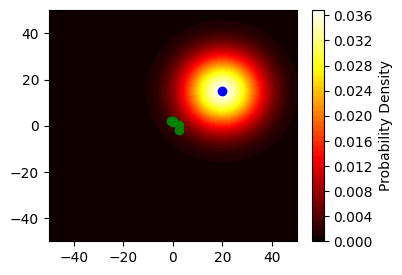

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -4.410263E+02 | -4.945581E+02
     2 |       20 | -4.556734E+02 | -5.096798E+02


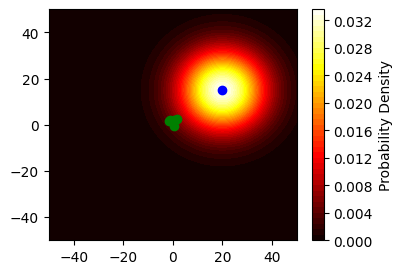

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -5.465757E+02 | -6.161999E+02
     2 |       20 | -5.622703E+02 | -6.161999E+02


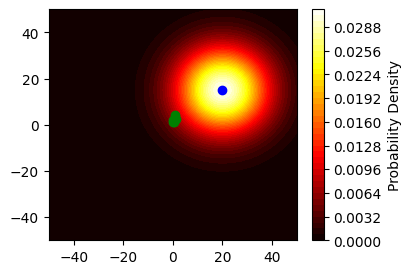

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -6.449132E+02 | -6.771350E+02
     2 |       20 | -6.542501E+02 | -6.771350E+02


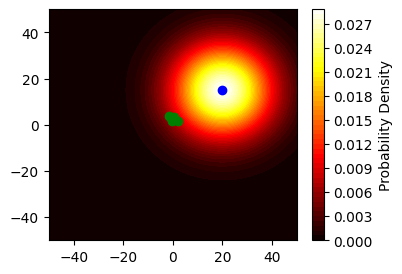

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -6.863159E+02 | -7.515361E+02
     2 |       20 | -7.030006E+02 | -7.515361E+02


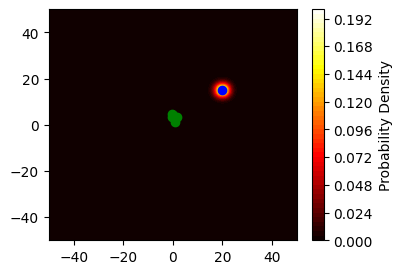

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -3.684421E+01 | -1.326041E+02
     2 |       20 | -6.486147E+01 | -1.326041E+02


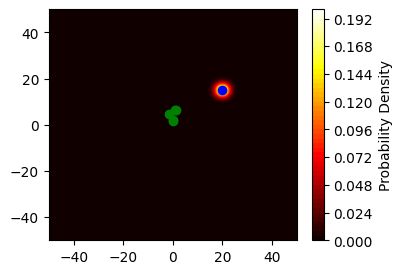

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -8.792176E+01 | -1.939348E+02
     2 |       20 | -1.215920E+02 | -1.939348E+02


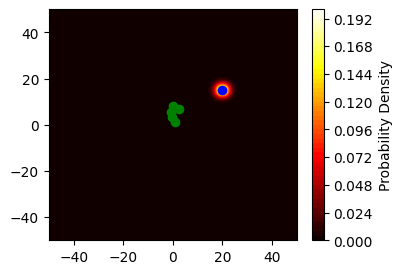

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -1.553288E+02 | -2.739298E+02
     2 |       20 | -1.929001E+02 | -2.838969E+02


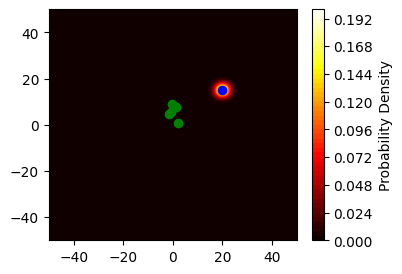

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -2.224471E+02 | -2.992235E+02


KeyboardInterrupt: 

In [14]:
finished=False
#Drone waypoints got from -25 to 25, Array from 0 to 50
#waypoints=np.array([[-5,0,35.],[-2,0,35.],[ 0,0,35.],[ 2,0,35.],[5,15,35.]])
#swarm.waypoints(ids,waypoints)

visibility_grid= "Null"
runNumber=0

#print(f"Starting with waypoints: \n {waypoints}")

sigma=10

print(f"Starting now, at {time.time() - start}")

dronePath= []
#dronePath = np.array([])
targetDetections = []

while not finished and runNumber<10:
    #print(f"Starting Run number {runNumber} at time: {time.time() - start} ")
    #print(f"Swarm is currently at\n {problem.waypoints}")
    runNumber+=1

    #get best solution
    res = minimize(problem, algorithm, termination, seed=1, verbose=True)
    _x= np.array(res.X)*4-2
    best_solution = _x.reshape(-1, 2)
    
    #update waypoints
    waypoints = waypoints + np.pad(best_solution,((0, 0), (0, 1)),mode='constant',constant_values=0)
    dronePath.append(np.array([waypoints]))
    problem.waypoints = waypoints
                     
    sigma+=1
    #if target was seen:
    best = res.opt[0]
    if best.get("aux1"):
        #print("Target Seen!\n Updating target Position and resetting Sigma")
        sigma = 2
        Last_Known_Position= Target_Position
        
        targetDetections.append([runNumber, 0])
            

    prob_density,x,y = getProbabilityGrid(Last_Known_Position,sigma)
    problem.prob_density = prob_density


    plt.figure(figsize=(4, 3))
    plt.contourf(x, y, prob_density, levels=50, cmap='hot')
    plt.colorbar(label='Probability Density')
    plt.scatter(Last_Known_Position[0],Last_Known_Position[1], color='blue', label='Last Known Position')
    plt.scatter(waypoints[:, 0],waypoints[:, 1], color='green', label='Drones')
    plt.show()

print(f"Drone Path:\n{dronePath}\n\n\n\n")
print(f"the average evaluation time per generation was {np.mean(evalTimings)} seconds")
print(f"\n\nTarget was first detected in Step {targetDetections[0][0]}")
#print("Target was detected")

In [ ]:
#Kill the Simulation

run(['pkill', '--full', 'gz sim server'])
print("gz sim server killed")
run(['pkill', '--full', 'gz sim gui'])
print("gz sim gui killed")

#print(process.communicate())